# An attempt to recreate the pre-processed BAM CR-Images from 2015

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.io import fits

In [3]:
from matplotlib.colors import LogNorm

We'll load the finished product so we can compare

In [212]:
reference = fits.getdata("../../datasets/bam_sif_extracted_ralf/2014-05/CR_000018330454284134300_2014-05-29.fits")
source = fits.getdata("../../datasets/sif_fits/2014-05-29/SIF_PROCESSING_CCD_ROW_1_BAM_WFS_OBMT_START_18330454283151500_CDP_IPHI_CLOCKING_VIG_7.989_VID_12.504.fits")

In [213]:
# another matching pair
#reference = fits.getdata("../../datasets/bam_sif_extracted_ralf/2014-10/CR_000029821614574780700_2014-10-09.fits")
#source = fits.getdata("../../datasets/sif_fits/2014-10-09/SIF_PROCESSING_CCD_ROW_1_BAM_WFS_OBMT_START_29821614573797900_CDP_IPHI_CLOCKING_VIG_7.989_VID_12.504.fits")

In [214]:
# another matching pair
#reference = fits.getdata("../../datasets/bam_sif_extracted_ralf/2015-01/CR_000037079221403653100_2015-01-01.fits")
#source = fits.getdata("../../datasets/sif_fits/2015-01-01/SIF_PROCESSING_CCD_ROW_1_BAM_WFS_OBMT_START_37079221402670300_CDP_IPHI_CLOCKING_VIG_7.989_VID_12.504.fits")

Grab the corresponding region out of the SIF image

In [253]:
extracted = np.zeros((721,141)) # final shape from the TN
extracted[1:,:] = np.copy(source[-819:-99,1:142]) # reading the TN, this should be the equivalent region
# note that row 1 is currently being kept empty - that's where the noise estimate would go

(721, 141)


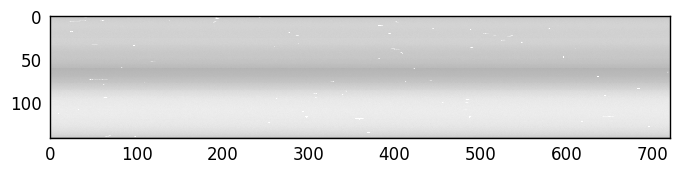

In [234]:
# plot it...
plt.grid(False)
plt.imshow(np.rot90(extracted,1),cmap='gray',norm=LogNorm(),vmin=1e3, vmax=4e3)
#plt.imshow(np.rot90(source[-99:,1:142],1),cmap='gray',norm=LogNorm(),vmin=1e3, vmax=4e3)
print(extracted.shape)

Now let's subtract off the unexposed values

In [255]:
# determine the background using outlier rejection
#unexposed = source[-99:,1:142].astype("float64")
unexposed = source[:100,1:142].astype("float64")  # not sure which one to take here
background = np.zeros(141)
sdevs = np.zeros(141)

# use sigma clipping
from astropy.stats import sigma_clip

unexposed = sigma_clip(unexposed,sigma=3,iters=None,axis=0)
sdevs = np.std(unexposed, axis=0)
background = np.mean(unexposed, axis=0)

background = np.rint(background).astype('uint16')


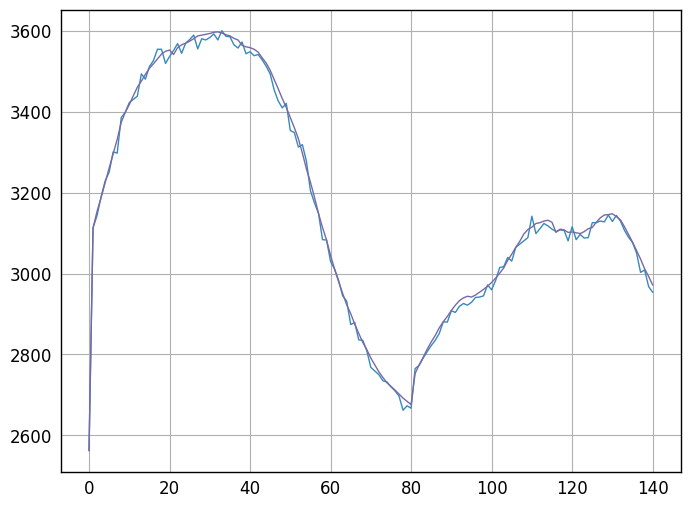

In [256]:
# plot for testing
plt.plot(extracted[-1,:])
plt.plot(background)

#plt.plot(np.rint(sdevs))
#plt.plot(reference[0,:])

In [257]:
# add the ADU offset level first
extracted[1:,:] += 1500
extracted[1:,:] -= background

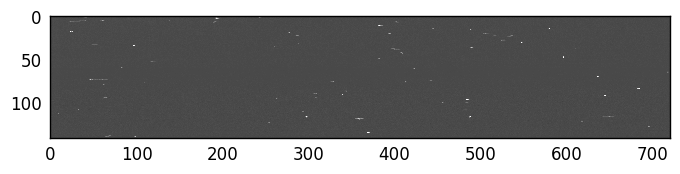

In [258]:
# plot it...
plt.grid(False)
plt.imshow(np.rot90(extracted,1),cmap='gray',norm=LogNorm(),vmin=1e3, vmax=4e3)

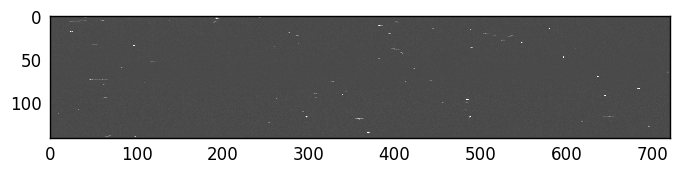

In [259]:
# compare to the reference
plt.grid(False)
plt.imshow(np.rot90(reference,1),cmap='gray',norm=LogNorm(),vmin=1e3,vmax=4e3)

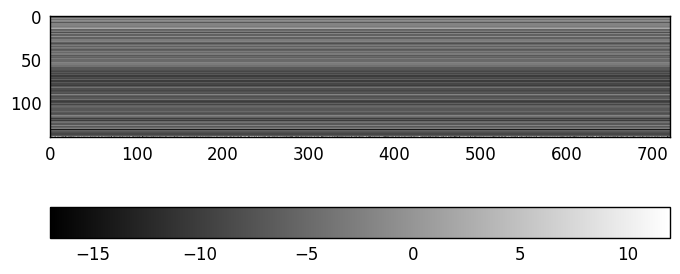

In [260]:
# let's compute the difference
diff = (extracted-reference).astype("int16") # type chosen such that we also have negative values

# plot it
plt.grid(False)
plt.imshow(np.rot90(diff,1),cmap='gray')
plt.colorbar(orientation="horizontal")

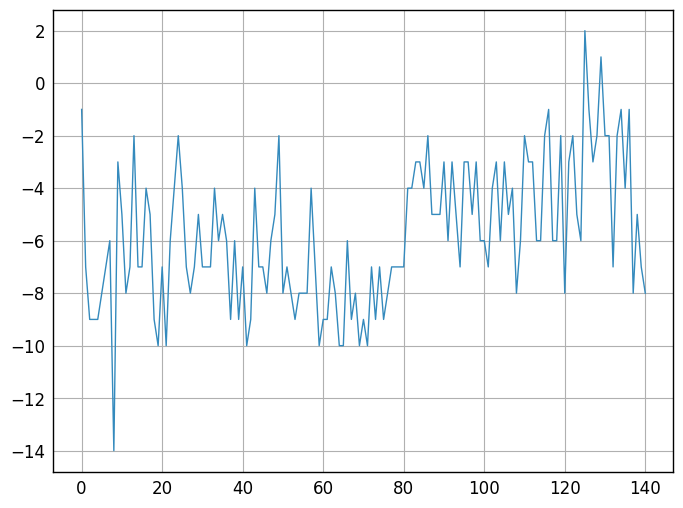

In [261]:
plt.plot(diff[cind,:])

Interestingly: Difference for constant AC is always constant while it shows drift for constant AL (especially after AC 80)

UPDATE: This does not happen when I pick the FIRST 99 TDI lines for my work. Instead, you get two different offset levels that are sadly still systematic.

Additionally, I need to take care of the noise estimation - this should be the sigmas calculated along the way